# Original OpenCV Image

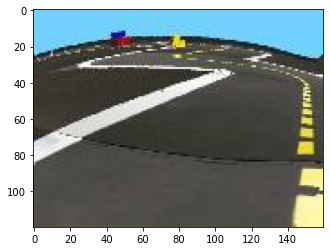

In [118]:
from cv2_plt_imshow import cv2_plt_imshow
import cv2
import numpy as np
image_num="000072"
img = cv2.imread(f"logs/segmentation_results/{image_num}_image.png")
cv2_plt_imshow(img)


In [121]:
def infer_cv2_image(sess_ort, img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    np_img = img_rgb.reshape((1,*img_rgb.shape))
    res = sess_ort.run(output_names=["output:0"], input_feed={"input_rgb:0": np_img.astype(np.float32)})
    seg=res[0].astype(np.uint8).squeeze()
    return seg

# Inference on RGB image

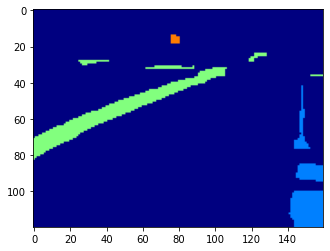

In [122]:
#seg = cv2.imread(f"logs/segmentation_results/{image_num}_raw_prediction.png",cv2.IMREAD_GRAYSCALE)
import onnxruntime as ort
sess_ort = ort.InferenceSession("./output/segmentation.onnx")
seg = infer_cv2_image(sess_ort, img)
#img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2_plt_imshow(cv2.applyColorMap(seg*64, cv2.COLORMAP_JET))

In [114]:
def get_lines_mask(seg):
    yellow = (seg==1).astype(np.uint8)
    white = (seg==2).astype(np.uint8)
    return yellow, white
yellow, white = get_lines_mask(seg)

In [18]:
class Point:
    """
    Point class. Convenience class for storing ROS-independent 3D points.
    """
    def __init__(self, x=None, y=None, z=None):
        self.x = x  #: x-coordinate
        self.y = y  #: y-coordinate
        self.z = z  #: z-coordinate

    @staticmethod
    def from_message(msg):
        """
        Generates a class instance from a ROS message. Expects that the message has attributes ``x`` and ``y``.
        If the message additionally has a ``z`` attribute, it will take it as well. Otherwise ``z`` will be set to 0.
        Args:
            msg: A ROS message or another object with ``x`` and ``y`` attributes
        Returns:
            :py:class:`Point` : A Point object
        """
        x = msg.x
        y = msg.y
        try:
            z = msg.z
        except AttributeError:
            z = 0
        return Point(x, y, z)
    def __str__(self):
        return f"{self.x}, {self.y}, {self.z}"

In [19]:
class GroundProjectionGeometry:
    """
    Handles the Ground Projection operations.
    Note:
        All pixel and image operations in this class assume that the pixels and images are *already rectified*! If
        unrectified pixels or images are supplied, the outputs of these operations will be incorrect!
    Args:
        im_width (``int``): Width of the rectified image
        im_height (``int``): Height of the rectified image
        homography (``int``): The 3x3 Homography matrix
    """

    def __init__(self, im_width, im_height, homography):
        self.im_width = im_width
        self.im_height = im_height
        self.H = np.array(homography).reshape((3, 3))
        self.Hinv = np.linalg.inv(self.H)

    def vector2pixel(self, vec):
        """
        Converts a ``[0,1] X [0,1]`` representation to ``[0, W] X [0, H]`` (from normalized to image coordinates).
        Args:
            vec (:py:class:`Point`): A :py:class:`Point` object in normalized coordinates. Only the ``x`` and ``y`` values are used.
        Returns:
            :py:class:`Point` : A :py:class:`Point` object in image coordinates. Only the ``x`` and ``y`` values are used.
        """
        x = self.im_width * vec.x
        y = self.im_height * vec.y
        return Point(x, y)

    def pixel2vector(self, pixel):
        """
        Converts a ``[0,W] X [0,H]`` representation to ``[0, 1] X [0, 1]`` (from image to normalized coordinates).
        Args:
            vec (:py:class:`Point`): A :py:class:`Point` object in image coordinates. Only the ``x`` and ``y`` values are used.
        Returns:
            :py:class:`Point` : A :py:class:`Point` object in normalized coordinates. Only the ``x`` and ``y`` values are used.
        """
        x = pixel.x / self.im_width
        y = pixel.y / self.im_height
        return Point(x, y)

    def pixel2ground(self, pixel):
        """
        Projects a normalized pixel (``[0, 1] X [0, 1]``) to the ground plane using the homography matrix.
        Args:
            pixel (:py:class:`Point`): A :py:class:`Point` object in normalized coordinates. Only the ``x`` and ``y`` values are used.
        Returns:
            :py:class:`Point` : A :py:class:`Point` object on the ground plane. Only the ``x`` and ``y`` values are used.
        """
        uv_raw = np.array([pixel.x, pixel.y, 1.0])
        ground_point = np.dot(self.H, uv_raw)
        point = Point()
        x = ground_point[0]
        y = ground_point[1]
        z = ground_point[2]
        point.x = x / z
        point.y = y / z
        point.z = 0.0
        return point

    def ground2pixel(self, point):
        """
        Projects a point on the ground plane to a normalized pixel (``[0, 1] X [0, 1]``) using the homography matrix.
        Args:
            point (:py:class:`Point`): A :py:class:`Point` object on the ground plane. Only the ``x`` and ``y`` values are used.
        Returns:
            :py:class:`Point` : A :py:class:`Point` object in normalized coordinates. Only the ``x`` and ``y`` values are used.
        Raises:
            ValueError: If the input point's ``z`` attribute is non-zero. The point must be on the ground (``z=0``).
        """
        if point.z != 0:
            msg = 'This method assumes that the point is a ground point (z=0). '
            msg += 'However, the point is (%s,%s,%s)' % (point.x, point.y, point.z)
            raise ValueError(msg)

        ground_point = np.array([point.x, point.y, 1.0])
        image_point = np.dot(self.Hinv, ground_point)
        image_point = image_point / image_point[2]

        pixel = Point()
        pixel.x = image_point[0]
        pixel.y = image_point[1]

        return pixel



In [20]:
import os, yaml
def load_extrinsics():
    """
    Loads the homography matrix from the extrinsic calibration file.
    Returns:
        :obj:`numpy array`: the loaded homography matrix
    """
    # load intrinsic calibration
    cali_file = "default_homography.yaml"

    # Locate calibration yaml file or use the default otherwise
    if not os.path.isfile(cali_file):
        self.log("Can't find calibration file: %s.\n Using default calibration instead."
                 % cali_file, 'warn')
        cali_file = (cali_file_folder + "default.yaml")

    # Shutdown if no calibration file not found
    if not os.path.isfile(cali_file):
        msg = 'Found no calibration file ... aborting'
        self.log(msg, 'err')
        rospy.signal_shutdown(msg)

    try:
        with open(cali_file,'r') as stream:
            calib_data = yaml.load(stream)
    except yaml.YAMLError:
        msg = 'Error in parsing calibration file %s ... aborting' % cali_file
        self.log(msg, 'err')
        rospy.signal_shutdown(msg)

    return calib_data['homography']

In [34]:
homography = load_extrinsics()
homography = np.array(homography).reshape((3, 3))
gpg = GroundProjectionGeometry(160,120, homography)

<ipython-input-20-eb01a6056480>:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  calib_data = yaml.load(stream)


In [73]:

yellow_points=None

if len(contours_yellow)>0:
    yellow_points = np.vstack(contours_yellow).reshape(-1,2)
    #yellow_points[:,1] = -yellow_points[:,1] + yellow.shape[0]
yellow_points_norm = yellow_points.copy().astype(float)
#yellow_points_norm[:,0]=yellow_points[:,0].astype(float)/160
#yellow_points_norm[:,1]=yellow_points[:,1].astype(float)/120


In [94]:
def get_line_segments_px(mask):
    contours,hierarchy = cv2.findContours(mask, 1, cv2.CHAIN_APPROX_SIMPLE )
    segments_px = []
    for cnt in contours:
        i=0
        pt1=None
        pt2=None
        for point in cnt:
            if i==0:
                pt1 = tuple(point[0])
                i=1
                continue
            if i==1:
                pt2 = tuple(point[0])
                segment = (pt1, pt2)
                segments_px.append(segment)
                i=0
                continue
    return segments_px
        #segment = ((cnt[]))

In [95]:
yellow_segments_px = get_line_segments_px(yellow)

In [96]:
white_segments_px = get_line_segments_px(white)

In [110]:
def ground_project_segments_px(segments_px):
    x=[]
    y=[]
    segments=[]
    for segment_px in segments_px:
        pixel1 = Point(segment_px[0][0]*4,segment_px[0][1]*4) #Conversion. Points are converted in 640x480 for the homography to work
        pixel2 = Point(segment_px[1][0]*4,segment_px[1][1]*4) #Conversion. Points are converted in 640x480 for the homography to work
        ground_projected_point1 = gpg.pixel2ground(pixel1)
        ground_projected_point2 = gpg.pixel2ground(pixel2)
        pt1 = (ground_projected_point1.x, ground_projected_point1.y)
        pt2 = (ground_projected_point2.x, ground_projected_point2.y)
        segment = (pt1,pt2)
        segments.append(segment)
    return segments
segments = ground_project_segments_px(white_segments_px)

In [111]:
x=[]
y=[]
for segment in segments:
    x.append(segment[0][0])
    x.append(segment[1][0])
    y.append(segment[0][1])
    y.append(segment[1][1])

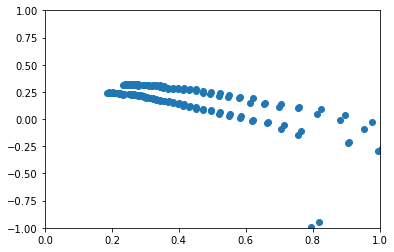

In [112]:
import matplotlib.pyplot as plt
plt.scatter(x,y)
plt.xlim([0,1])
plt.ylim([-1,1])
plt.show()